In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import json
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
import pandas as pd
import copy

%run ./result_summary.ipynb

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Define plot defaults
# mpl.rcParams['figure.figsize'] = (14.0, 7.0)
# mpl.rcParams['font.family'] = "Times New Roman"
# mpl.rcParams['axes.grid'] = True
# mpl.rcParams['axes.titlesize'] = 20
# mpl.rcParams['axes.labelsize'] = 16


print(plt.style.available)
plt.style.use('seaborn')
plt.style.use('seaborn-poster')
output_path = '/Users/kobibi/WorkDocs/DeepPNML-Paper/figures'
is_plot_title = False
is_save_fig = True

['_classic_test', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10']


# NML Vs. ERM Performence
NML is as training is as following:
1. Train base model with all trainset
2. Freeze first layers (only enable updates of layer 5,6 in resnet20)
3. For each test sample:
    1. For each label:
        1. Add the test sample with the label to trainset
        2. Train for 10 epochs the model
        3. Keep probability of the test sample label which it was trained with
    2. Take all save probabilities and normalize them.
    3. Report the new probability assignmnet

In [3]:
# Print acc and mean loss
tic = time.time()
result_df, statistics_df = load_results_to_df(files_nml_2_layers)
print('result_df: loaded in {0:.2f} [s]'.format(time.time()-tic))
print(statistics_df.transpose())

result_df: loaded in 2.45 [s]
          acc  mean loss  std loss  mean entropy
nml    0.9184   0.167210  0.313679      0.197706
erm    0.9183   0.194359  0.821636      0.024840
genie  0.9875   0.027294  0.230810      0.024752


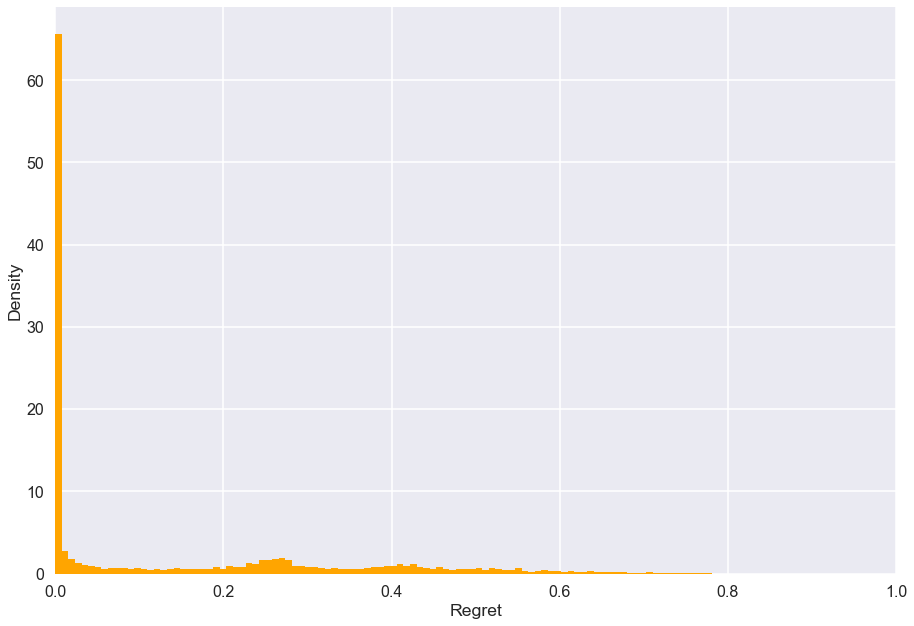

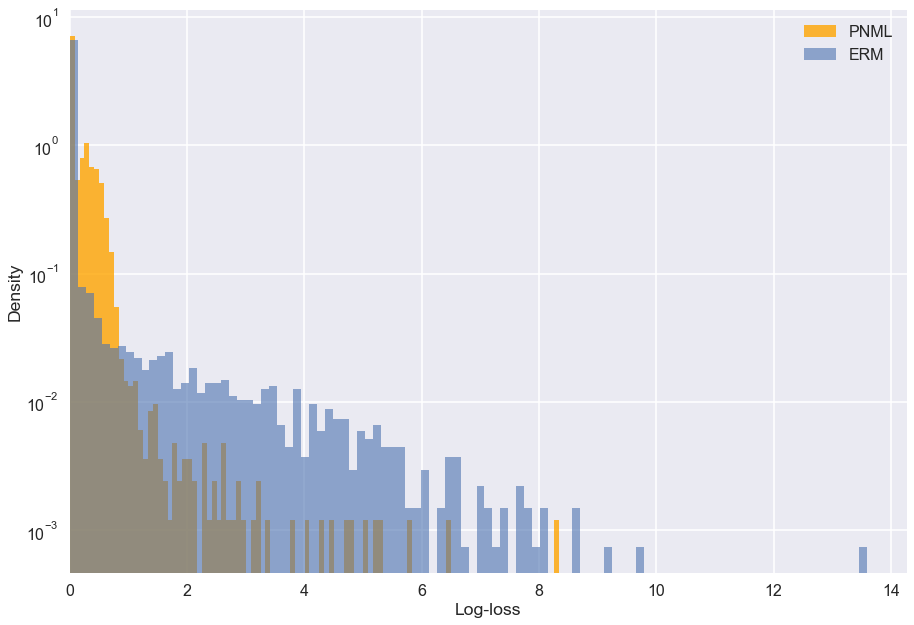

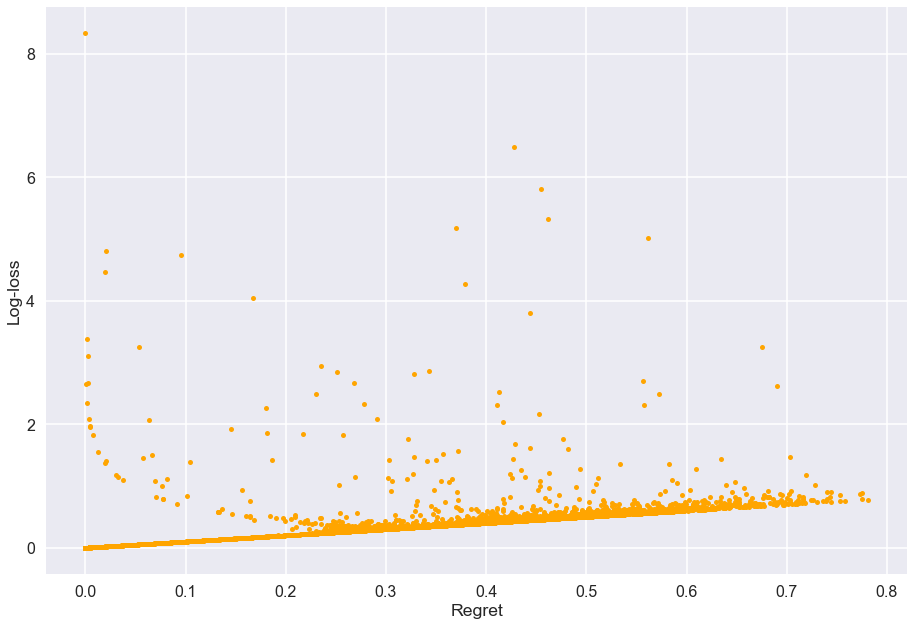

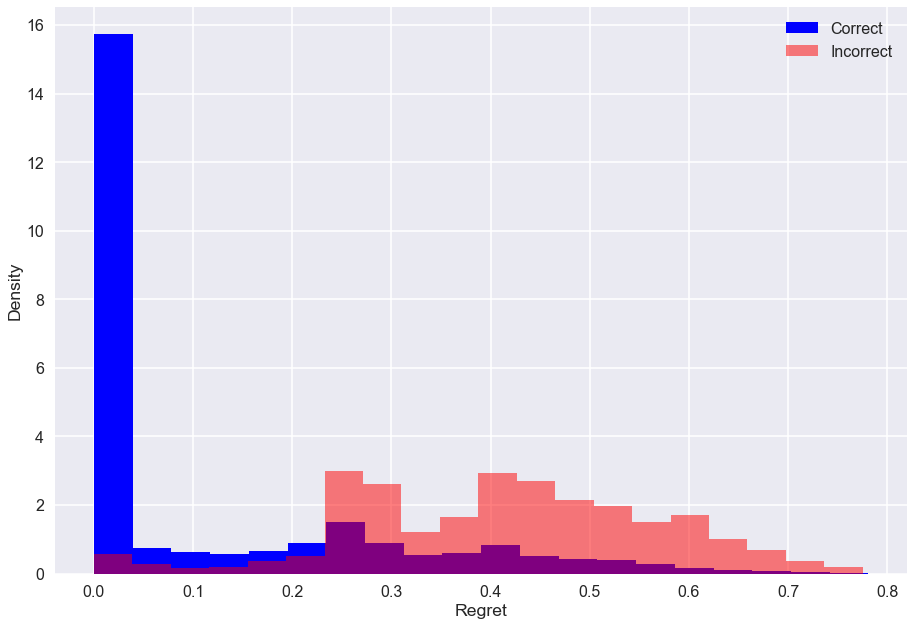

Correct = 9184, Incorrect = 816 
Mean [correct, incorrect]=[0.1156757391744595, 0.41274406045452866]


In [4]:
# Regret histogram
bins = 100
plt.hist(result_df['log10_norm_factor'], density=True, label='PNML', bins=bins, color='orange')
plt.xlim([-0.0001,1])
plt.title('Regret Histogram') if is_plot_title else None
plt.xlabel('Regret')
plt.ylabel('Density')
plt.savefig(os.path.join(output_path, 'regret_hist.jpg'), dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# logloss histogram
bins = 100
plt.hist(result_df['nml_loss'], bins=bins, alpha=0.8, label='PNML', density=True, color='orange')
plt.hist(result_df['erm_loss'], bins=bins, alpha=0.6, label='ERM', density=True)
plt.title('Logloss Histogram') if is_plot_title else None
plt.xlabel('Log-loss')
plt.ylabel('Density')
plt.yscale('log')
plt.xlim(left=0)
plt.legend()
plt.savefig(os.path.join(output_path, 'logloss_hist.jpg'), dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# Loss vs. NML nomralization factor
# plt.plot(result_df['log10_norm_factor'], result_df['erm_loss'], 
#          linestyle='None', color='blue', marker='^', label='ERM')
plt.plot(result_df['log10_norm_factor'], result_df['nml_loss'], 
         linestyle='None', color='orange', marker='o', label='PNML', markersize=5)
plt.title('Log-loss Vs. Regret')  if is_plot_title else None
plt.xlabel('Regret')
plt.ylabel('Log-loss')
# plt.xlim([-0.001,1])
# plt.legend()
plt.savefig(os.path.join(output_path, 'loss_vs_regret.jpg'), dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# Plot histogram of correct vs incorrect
bins= 20
correct_norm_factor = result_df['log10_norm_factor'][result_df['nml_is_correct'] == True]
incorrect_norm_factor = result_df['log10_norm_factor'][result_df['nml_is_correct'] == False]
plt.hist(correct_norm_factor, alpha=1, bins=bins, density=True, color='blue', label='Correct')
plt.hist(incorrect_norm_factor, alpha=0.5, bins=bins, density=True, color='red', label='Incorrect')
plt.title('Regret Histogram with Correct and Incorrect Separation')  if is_plot_title else None
plt.xlabel('Regret')
plt.ylabel('Density')
# plt.yscale('symlog')
# plt.xlim([-0.001,1])
plt.legend()
plt.savefig(os.path.join(output_path, 'correct_incorrect_hist.jpg'), dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()
print('Correct = %d, Incorrect = %d '% (correct_norm_factor.shape[0], incorrect_norm_factor.shape[0]))
print('Mean [correct, incorrect]={}'.format([correct_norm_factor.mean(), incorrect_norm_factor.mean()])) 

# Compose estimator based on the regret

In [5]:
#  Construct best loss based on normalization factor
threshold_list = np.linspace(np.finfo(float).eps,1,99)
acc_list = []
cdf_list = []
nml_thresh_loss_list = []
for threshold in threshold_list:
    
    df = result_df[result_df['log10_norm_factor']<threshold]
    
    # loss
    nml_thresh_loss_list.append(df['nml_loss'].mean())
        
    # Acc
    acc_single =  np.sum(df['nml_is_correct'] == True) / (df.shape[0] + np.finfo(float).eps)
    acc_list.append(acc_single)
    
    cdf_single = df.shape[0] / result_df.shape[0]
    cdf_list.append(cdf_single)  

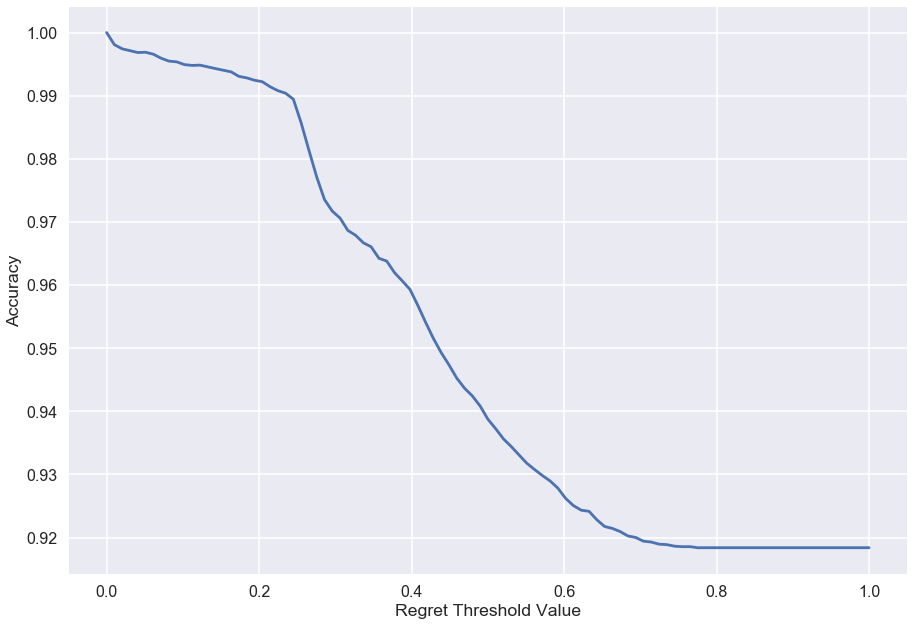

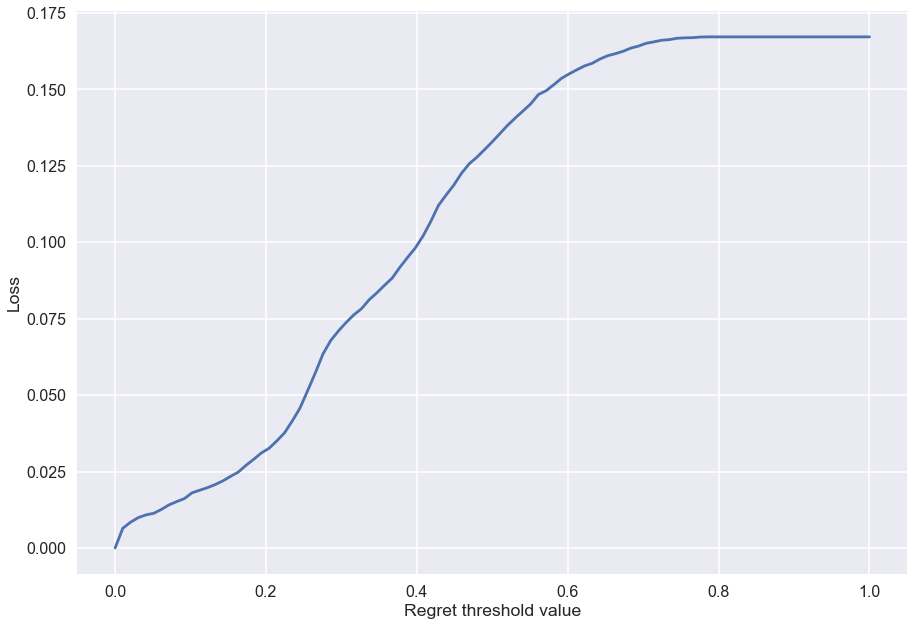

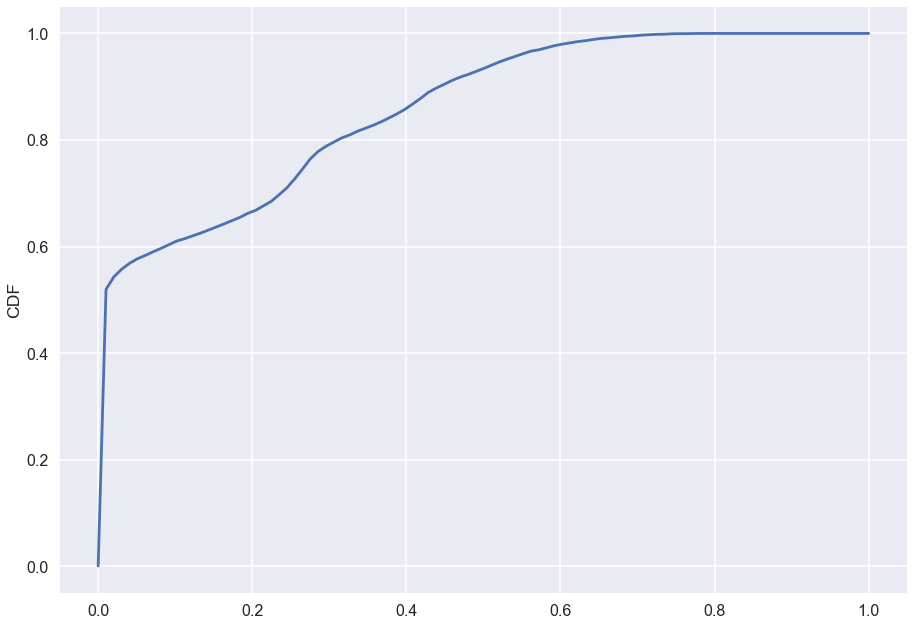

In [6]:
# Plot Acc
plt.plot(threshold_list, acc_list, label='Thresholded')
plt.xlabel('Regret Threshold Value')
plt.ylabel('Accuracy')
plt.title('Accuracy with threshold between PNML and None')  if is_plot_title else None
plt.savefig(os.path.join(output_path, 'regret_based_calss_acc.jpg'), dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# Plot PNML loss
plt.plot(threshold_list, nml_thresh_loss_list, label='NML loss')
plt.xlabel('Regret threshold value')
plt.ylabel('Loss')
plt.title('PNML loss vs. Threshold Values') if is_plot_title else None
plt.savefig(os.path.join(output_path, 'regret_based_calss_loss.jpg'), dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# Plot CDF
plt.plot(threshold_list, cdf_list, label='Threshold Acc CDF')
plt.xlabel('Regret Threshold value')  if is_plot_title else None
plt.ylabel('CDF')
plt.title('CDF vs. Threshold Values') if is_plot_title else None
plt.savefig(os.path.join(output_path, 'regret_based_calss_cdf.jpg'), dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

In [7]:
n = 2
print(pd.DataFrame({'CDF': cdf_list[::n], 'Acc': acc_list[::n], 'Log-loss': nml_thresh_loss_list[::n]}))

       CDF       Acc      Log-loss
0   0.0008  1.000000 -4.821637e-17
1   0.5434  0.997424  8.419740e-03
2   0.5688  0.996835  1.081180e-02
3   0.5835  0.996572  1.258863e-02
4   0.5968  0.995476  1.517705e-02
5   0.6105  0.994922  1.805179e-02
6   0.6201  0.994840  1.972531e-02
7   0.6309  0.994294  2.194766e-02
8   0.6425  0.993774  2.482284e-02
9   0.6547  0.992821  2.899206e-02
10  0.6679  0.992214  3.260158e-02
11  0.6848  0.990800  3.763962e-02
12  0.7103  0.989441  4.570816e-02
13  0.7457  0.981360  5.723900e-02
14  0.7788  0.973549  6.783632e-02
15  0.7963  0.970614  7.373194e-02
16  0.8096  0.967885  7.825885e-02
17  0.8221  0.966063  8.346332e-02
18  0.8342  0.963798  8.831578e-02
19  0.8491  0.960664  9.507507e-02
20  0.8676  0.956777  1.020428e-01
21  0.8894  0.951540  1.120543e-01
22  0.9044  0.947368  1.187236e-01
23  0.9178  0.943670  1.256824e-01
24  0.9283  0.940860  1.303408e-01
25  0.9403  0.937254  1.355997e-01
26  0.9517  0.934433  1.407022e-01
27  0.9617  0.931787

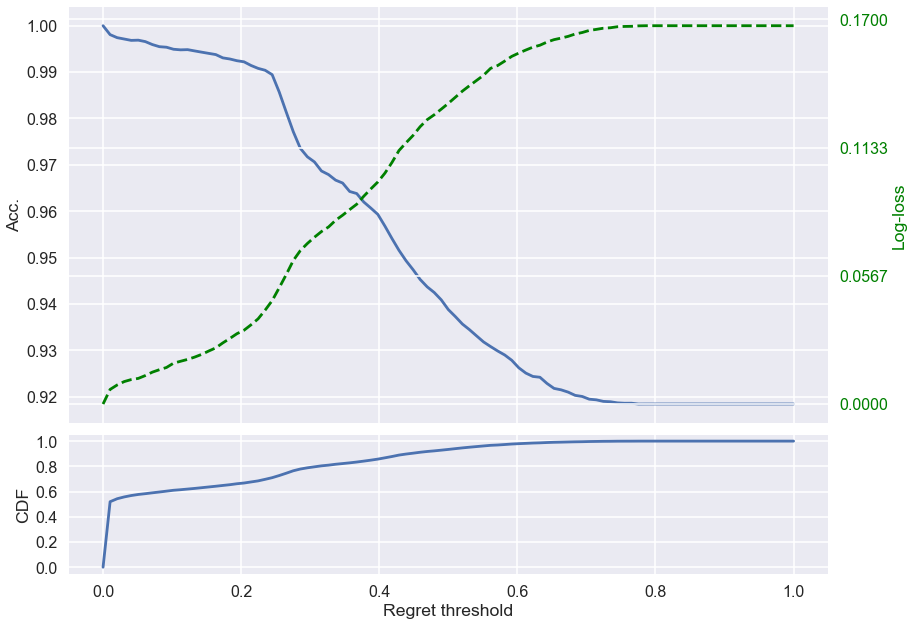

In [8]:
from matplotlib import gridspec
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 

# Acc
ax1=plt.subplot(gs[0])
ax1.plot(threshold_list,acc_list, '-')
ax1.set_ylabel('Acc.')
ax1.tick_params('y')
# ax1.get_xaxis().set_visible(False)

labels = [item.get_text() for item in ax1.get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax1.set_xticklabels(empty_string_labels)

# Loss
ax2 = ax1.twinx()
ax2.plot(threshold_list, nml_thresh_loss_list, 'g--')
ax2.set_yticks(np.linspace(np.min(nml_thresh_loss_list).round(2), 
                           np.max(nml_thresh_loss_list).round(2), 4))
ax2.set_ylabel('Log-loss', color='green')
ax2.tick_params('y', colors='green')
ax2.get_xaxis().set_visible(False)

# CDF
ax3=plt.subplot(gs[1])
ax3.plot(threshold_list, cdf_list)
ax3.set_yticks(np.linspace(0, 1, 6))
ax3.set_xlabel('Regret threshold')
ax3.set_ylabel('CDF')


plt.savefig(os.path.join(output_path, 'regret_based_calss_all.jpg'), dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()



# Top K accuracy

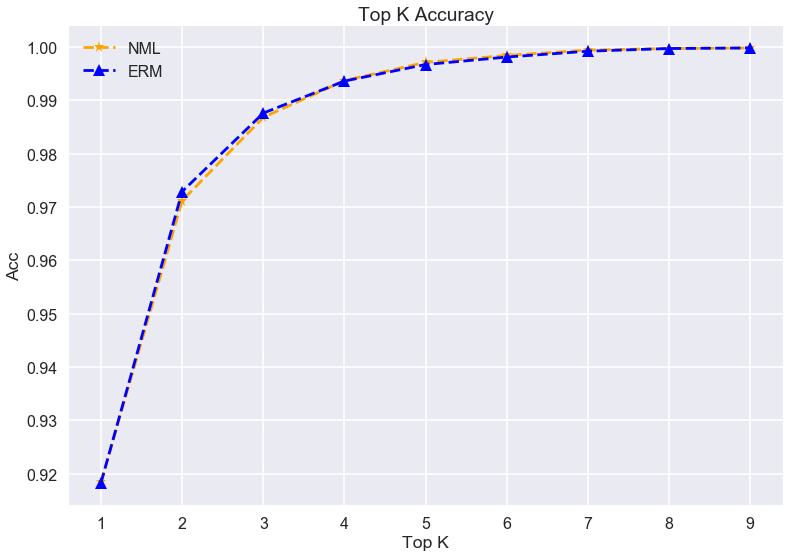

In [9]:
results_dict = load_dict_from_file_list(files_nml_2_layers)

acc_top_k_nml_list, acc_top_k_erm_list  = [], []
for k in range(1,10):
    acc_top_k_nml, acc_top_k_erm = calculate_top_k_acc(results_dict,k)
    acc_top_k_nml_list.append(acc_top_k_nml)
    acc_top_k_erm_list.append(acc_top_k_erm)
    

plt.plot(list(range(1,10)),acc_top_k_nml_list, '--*' , label='NML', color='orange')
plt.plot(list(range(1,10)),acc_top_k_erm_list, '--^' , label='ERM', color='blue')
plt.xlabel('Top K')
plt.ylabel('Acc')
plt.title('Top K Accuracy')
plt.legend()
plt.show()

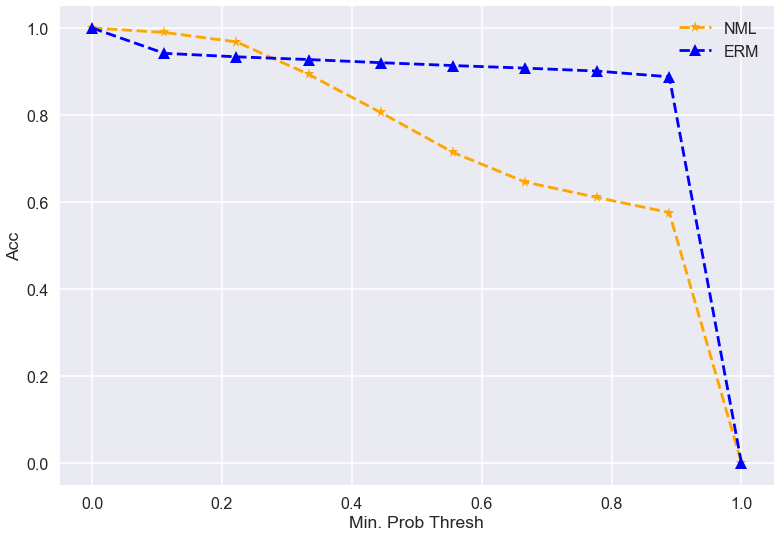

In [10]:
results_dict = load_dict_from_file_list(files_nml_2_layers)
acc_top_k_nml_list, acc_top_k_erm_list  = [], []
prob_thresh_list = np.linspace(0,1,10)
for prob_thresh in prob_thresh_list:
    acc_top_k_nml, acc_top_k_erm = calculate_top_k_acc(results_dict,10, prob_thresh)
    acc_top_k_nml_list.append(acc_top_k_nml)
    acc_top_k_erm_list.append(acc_top_k_erm)
    

plt.plot(prob_thresh_list,acc_top_k_nml_list, '--*' , label='NML', color='orange')
plt.plot(prob_thresh_list,acc_top_k_erm_list, '--^' , label='ERM', color='blue')
plt.xlabel('Min. Prob Thresh')
plt.ylabel('Acc')
plt.title('True label probability higher then Min. Prob Thresh')  if is_plot_title else plt
plt.legend()
plt.show()

# Out  of Disterbution

In [11]:
# Load svhn and noise
results_df_cifar10, statistic_cifar10 = load_results_to_df(files_nml_2_layers)
print('Cifar10: loaded %d keys' % results_df_cifar10.shape[0])
results_df_noise, statistic_noise = load_results_to_df(files_noise, w_genie=False)
print('Noise: loaded %d keys' % results_df_noise.shape[0])
results_df_svhn, statistic_svhn = load_results_to_df(files_svhn, w_genie=False)
print('SVHN: loaded %d keys' % results_df_svhn.shape[0])

Cifar10: loaded 10000 keys
Noise: loaded 100 keys
SVHN: loaded 100 keys


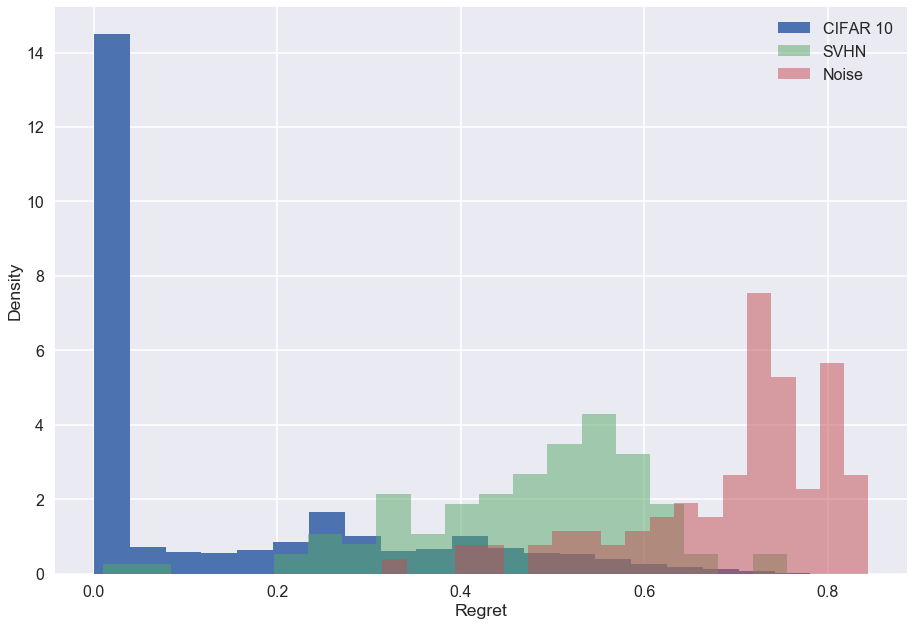

Mean: cifar, svhn, noise: [0.13991651419091314, 0.47305804001135926, 0.6994421087314094]


In [12]:
#Plot
bins = 20
plt.hist(results_df_cifar10['log10_norm_factor'], alpha=1, density=True, label='CIFAR 10', bins=bins)
plt.hist(results_df_svhn['log10_norm_factor'], alpha=0.5, density=True, label='SVHN', bins=bins)
plt.hist(results_df_noise['log10_norm_factor'], alpha=0.5, density=True, label='Noise', bins=bins)
# plt.xlim([0,1])
plt.ylabel('Density')
plt.xlabel('Regret')
plt.title('Out Of Distribution Regret Histogram')  if is_plot_title else None
plt.savefig(os.path.join(output_path, 'out_of_dist_hist.jpg'), 
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.legend()
plt.show()
print('Mean: cifar, svhn, noise: {}'.format([results_df_cifar10['log10_norm_factor'].mean(), 
                                             results_df_svhn['log10_norm_factor'].mean(), 
                                             results_df_noise['log10_norm_factor'].mean()]))

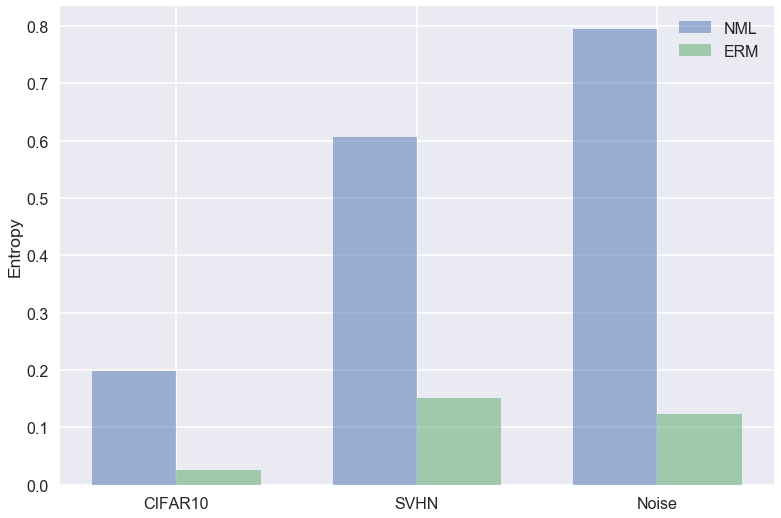

In [13]:
# Plot entropy
objects = ('CIFAR10', 'SVHN', 'Noise' )
y_pos = np.arange(len(objects))
bar_width = 0.35
opacity = 0.8

plt.bar(y_pos - bar_width/2, [statistic_cifar10.loc['mean entropy']['nml'],
                  statistic_svhn.loc['mean entropy']['nml'],
                  statistic_noise.loc['mean entropy']['nml']], bar_width, alpha=0.5, label='NML')

plt.bar(y_pos+bar_width/2, [statistic_cifar10.loc['mean entropy']['erm'],
                  statistic_svhn.loc['mean entropy']['erm'],
                  statistic_noise.loc['mean entropy']['erm']], bar_width, alpha=0.5, label='ERM')
 
plt.xticks(y_pos, objects)
plt.ylabel('Entropy') 
plt.title('Entropy of out of distribution sampels') if is_plot_title else None
plt.legend()
plt.show()

# Compare Training layers: 7, 5, 2
As opposite to the previous section, here all the model was trained and not only the 2 last layers

In [14]:
# Load results files into df
result_2_layers_df, _ = load_results_to_df(files_nml_2_layers)
result_5_layers_df, _ = load_results_to_df(files_nml_5_layers)
result_7_layers_df, _ = load_results_to_df(files_nml_7_layers)

# Create combined dataframe
col_to_keep = ['nml_loss', 'nml_is_correct']

result_0_layers_df = result_2_layers_df[['erm_loss', 'erm_is_correct']]
result_0_layers_df.columns = ['nml_loss_0_layers', 'nml_is_correct_0_layers']
result_2_layers_df = result_2_layers_df[col_to_keep]
result_2_layers_df.columns = ['nml_loss_2_layers', 'nml_is_correct_2_layers']
result_5_layers_df = result_5_layers_df[col_to_keep]
result_5_layers_df.columns = ['nml_loss_5_layers', 'nml_is_correct_5_layers']
result_7_layers_df = result_7_layers_df[col_to_keep]
result_7_layers_df.columns = ['nml_loss_7_layers', 'nml_is_correct_7_layers']

combined_df = pd.concat([result_0_layers_df, result_2_layers_df, result_5_layers_df, result_7_layers_df], 
                        axis=1, join='inner')
combined_df.head()

,nml_loss_0_layers,nml_is_correct_0_layers,nml_loss_2_layers,nml_is_correct_2_layers,nml_loss_5_layers,nml_is_correct_5_layers,nml_loss_7_layers,nml_is_correct_7_layers
0,-9.643275e-17,True,2.151972e-07,True,1.208843e-03,True,1.239797e-04,True
1,-9.643275e-17,True,4.679210e-06,True,2.471130e-02,True,2.093676e-03,True
10,1.863794e-06,True,2.555111e-01,True,5.063146e-01,True,4.386285e-01,True
11,-9.643275e-17,True,2.682267e-11,True,2.107107e-09,True,1.339399e-09,True
12,3.176553e-01,False,4.814189e-01,True,6.014721e-01,False,5.401038e-01,False


Num of samples: 136


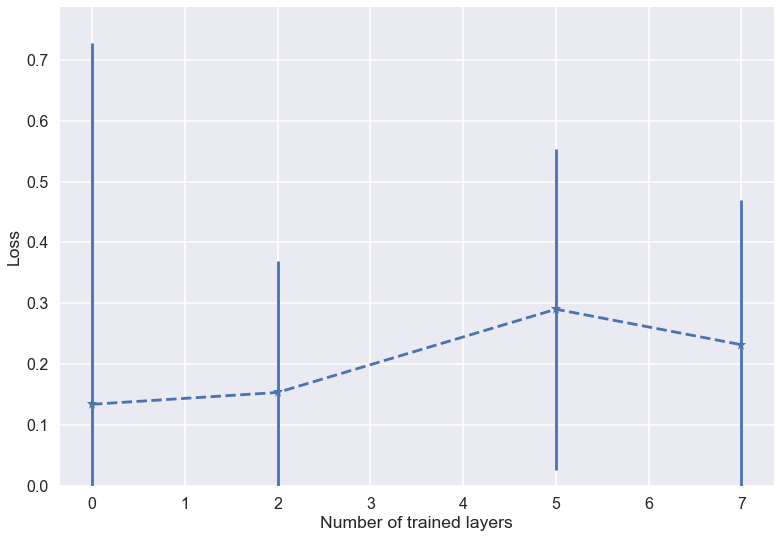

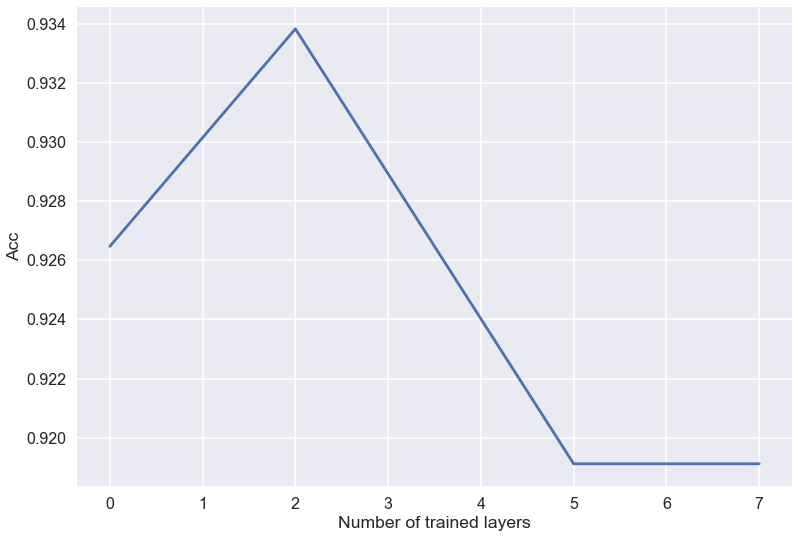

In [15]:
# Calculate statistic
mean_loss = np.mean([combined_df['nml_loss_0_layers'],
                     combined_df['nml_loss_2_layers'],
                     combined_df['nml_loss_5_layers'],
                     combined_df['nml_loss_7_layers']], axis=1)
std_loss = np.std([combined_df['nml_loss_0_layers'],
                     combined_df['nml_loss_2_layers'],
                     combined_df['nml_loss_5_layers'],
                     combined_df['nml_loss_7_layers']], axis=1)

acc = [np.sum(combined_df['nml_is_correct_0_layers'] == True) / combined_df.shape[0],
       np.sum(combined_df['nml_is_correct_2_layers'] == True) / combined_df.shape[0],
       np.sum(combined_df['nml_is_correct_5_layers'] == True) / combined_df.shape[0],
       np.sum(combined_df['nml_is_correct_7_layers'] == True) / combined_df.shape[0]]
       

print('Num of samples: %d' % combined_df.shape[0] )
plt.errorbar([0, 2, 5, 7], mean_loss, yerr=std_loss, fmt='--*')
plt.ylim(bottom=0)
plt.title('Loss Vs. Number of trained layers')  if is_plot_title else None
plt.xlabel('Number of trained layers')
plt.ylabel('Loss')
plt.show()


plt.plot([0, 2, 5, 7], acc)
plt.title('Acc Vs. Number of trained layers')  if is_plot_title else None
plt.xlabel('Number of trained layers')
plt.ylabel('Acc')
plt.show()

# Random labels

In [16]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import json
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
import pandas as pd
import copy

%run ./result_summary.ipynb

In [17]:
# Count param diffrence between WideResnet and Resnet20
from wide_resnet import WideResNet
from resnet import resnet20
model = WideResNet()
wide_resnet_params = sum(p.numel() for p in model.parameters())
model = resnet20()
resnet20_params = sum(p.numel() for p in model.parameters())
print('[WideResnet Resnet20]=[{} {}]'.format(wide_resnet_params, resnet20_params))
print('Ratio {}]'.format(wide_resnet_params/resnet20_params))

[WideResnet Resnet20]=[369498 269722]
Ratio 1.3699216230044269]


In [18]:
# Extract the log normalization factor
random_df = pd.DataFrame(columns=['nml_acc', 'erm_acc', 'genie_acc', 
                                  'log10_norm_factor', 
                                  'nml_mean_loss', 'erm_mean_loss', 'genie_mean_loss', 
                                  'nml_entropy', 'erm_entropy', 'genie_entropy'])
# for (rand_prob_single, file_random) in zip(random_prob, files_random):
for (rand_prob_single, file_random) in zip(random_prob, files_random_2_layers):

    results_df, statistics_df = load_results_to_df(file_random, is_random_labels=True)
    print('Random Prob = {}, num={}'.format(rand_prob_single, results_df.shape[0]))
    random_df.loc[rand_prob_single] = [statistics_df.loc['acc']['nml'],
                                       statistics_df.loc['acc']['erm'],
                                       statistics_df.loc['acc']['genie'],
                                       results_df['log10_norm_factor'].mean(),
                                       statistics_df.loc['mean loss']['nml'],
                                       statistics_df.loc['mean loss']['erm'],
                                       statistics_df.loc['mean loss']['genie'],
                                       statistics_df.loc['mean entropy']['nml'],
                                       statistics_df.loc['mean entropy']['erm'],
                                       statistics_df.loc['mean entropy']['genie']
                                      ]
print('Random df:')
print(random_df)

Random Prob = 0.0, num=156
Random Prob = 0.01, num=159
Random Prob = 0.03, num=156
Random Prob = 0.1, num=163
Random Prob = 0.3, num=155
Random Prob = 0.5, num=159
Random Prob = 0.6, num=153
Random Prob = 1.0, num=159
Random df:
       nml_acc   erm_acc  genie_acc  log10_norm_factor  nml_mean_loss  \
0.00  0.826923  0.820513   0.980769           0.312155       0.376550   
0.01  0.830189  0.830189   0.981132           0.361912       0.393191   
0.03  0.833333  0.839744   0.980769           0.412877       0.442201   
0.10  0.742331  0.779141   0.944785           0.590935       0.608947   
0.30  0.625806  0.664516   0.748387           0.642699       0.739662   
0.50  0.427673  0.509434   0.622642           0.728194       0.938783   
0.60  0.307190  0.366013   0.464052           0.738147       1.252855   
1.00  0.100629  0.100629   0.106918           0.583300       3.549829   

      erm_mean_loss  genie_mean_loss  nml_entropy  erm_entropy  genie_entropy  
0.00       0.704818         0.064

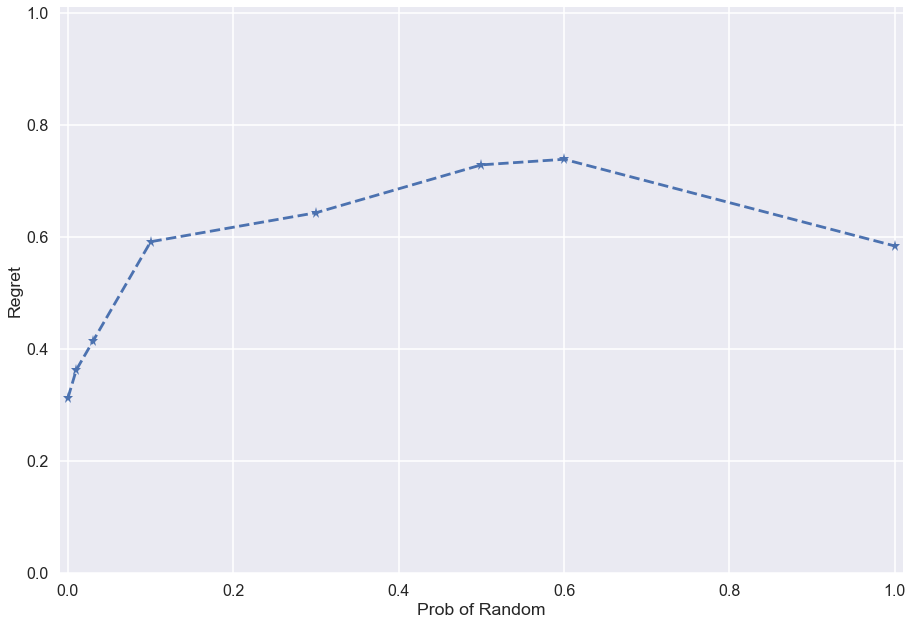

In [19]:
# Plot 
plt.plot(random_df.index.values,  random_df['log10_norm_factor'], '--*',  label='NML')
plt.ylabel('Regret')
plt.xlabel('Prob of Random')
plt.title('Regret Vs. Prob to be Random')  if is_plot_title else None
plt.ylim([0,1.01])
plt.xlim([-0.01,1.01])
# plt.xscale('symlog')
plt.savefig(os.path.join(output_path, 'random_prob_regret.jpg'), dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

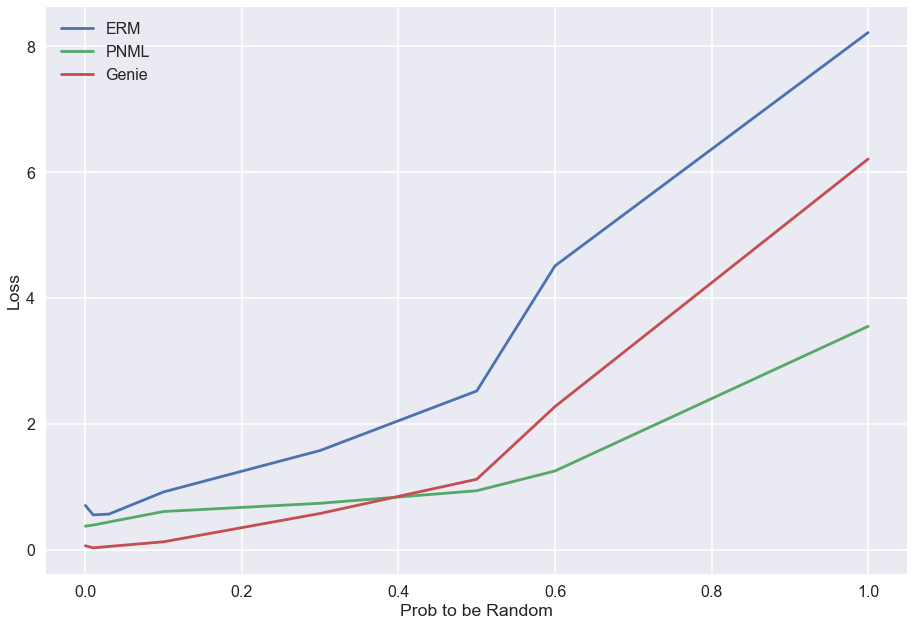

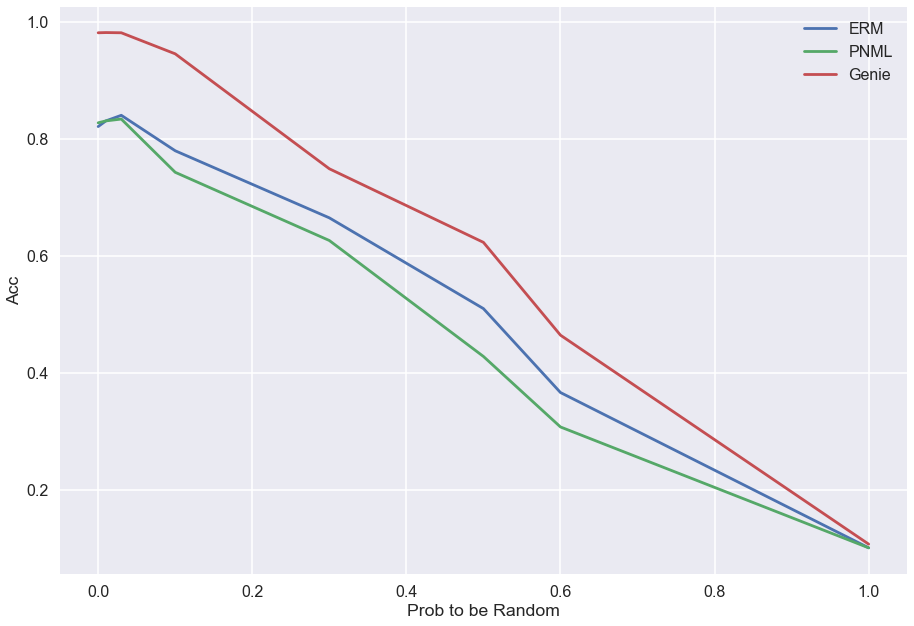

In [20]:
# Check noisy data
plt.plot(random_df.index.values,  random_df['erm_mean_loss'], label='ERM')
plt.plot(random_df.index.values,  random_df['nml_mean_loss'], label='PNML')
plt.plot(random_df.index.values,  random_df['genie_mean_loss'], label='Genie')
plt.title('Loss of random labels')  if is_plot_title else None
plt.ylabel('Loss')
plt.xlabel('Prob to be Random')
plt.legend()
plt.savefig(os.path.join(output_path, 'random_prob_loss.jpg'), dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

plt.plot(random_df.index.values,  random_df['erm_acc'], label='ERM')
plt.plot(random_df.index.values,  random_df['nml_acc'], label='PNML')
plt.plot(random_df.index.values,  random_df['genie_acc'], label='Genie')
plt.title('Acc of random labels')  if is_plot_title else None
plt.ylabel('Acc')
plt.xlabel('Prob to be Random')
plt.legend()
plt.savefig(os.path.join(output_path, 'random_prob_acc.jpg'), dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

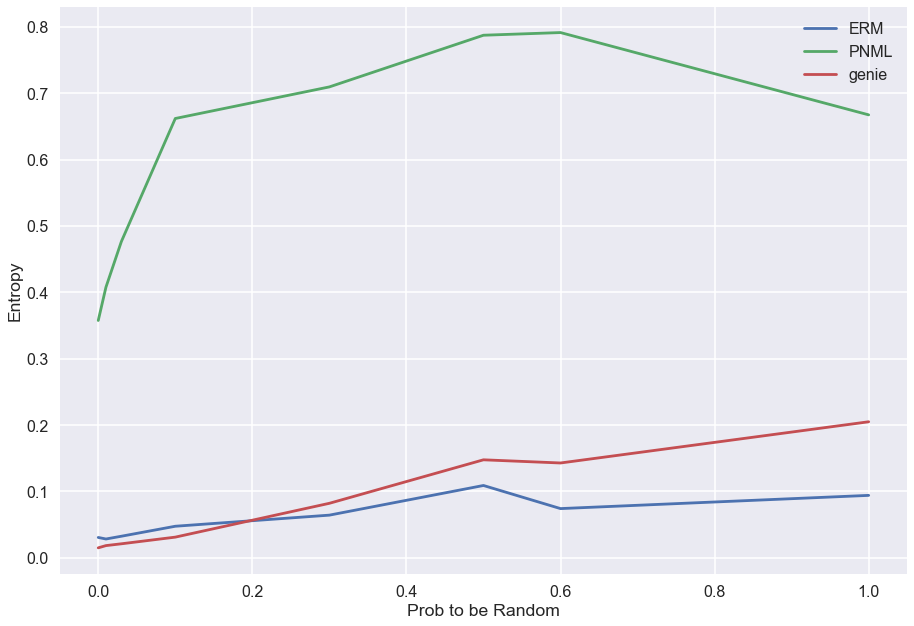

In [21]:
# Plot entropy
plt.plot(random_df.index.values,  random_df['erm_entropy'], label='ERM')
plt.plot(random_df.index.values,  random_df['nml_entropy'], label='PNML')
plt.plot(random_df.index.values,  random_df['genie_entropy'], label='genie')
plt.title('Entropy of random labels')  if is_plot_title else None
plt.ylabel('Entropy')
plt.xlabel('Prob to be Random')
plt.legend()
plt.savefig(os.path.join(output_path, 'random_prob_entropy.jpg'), dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

## Twice Universality

In [22]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import json
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
import pandas as pd
import copy

%run ./result_summary.ipynb

### Cifar

In [23]:
print('load 0 layers')
nml_0_df = result_dict_to_erm_df(load_dict_from_file_list(files_nml_2_layers))
print('load 2 layers')
nml_2_df = result_dict_to_nml_df(load_dict_from_file_list(files_nml_2_layers))
print('load 7 layers')
nml_7_df = result_dict_to_nml_df(load_dict_from_file_list(files_nml_7_layers))

# Create twice df dataframe
twice_df, idx_common = create_twice_univ_df([nml_0_df, nml_2_df, nml_7_df])
twice_statistic_df = calc_statistic_from_df_single(twice_df).rename(columns={'statistics': 'Twice Univ'})

# Print statistic of all
twice_statistic_df = calc_statistic_from_df_single(twice_df).rename(columns={'statistics': 'Twice Univ'})
nml_0_statistic_df = calc_statistic_from_df_single(nml_0_df.loc[idx_common]).rename(columns={'statistics': 
                                                                                             '0 layers'})
nml_2_statistic_df = calc_statistic_from_df_single(nml_2_df.loc[idx_common]).rename(columns={'statistics': 
                                                                                             '2 layers'})
nml_7_statistic_df = calc_statistic_from_df_single(nml_7_df.loc[idx_common]).rename(columns={'statistics': 
                                                                                             '7 layers'})
#--
pd.concat([twice_statistic_df, 
           nml_0_statistic_df,
           nml_2_statistic_df, 
           nml_7_statistic_df],  axis=1, join='inner')

load 0 layers
load 2 layers
load 7 layers


,Twice Univ,0 layers,2 layers,7 layers
acc,0.920000,0.920000,0.921000,0.913000
mean loss,0.167840,0.203024,0.173071,0.243650
std loss,0.250537,0.867517,0.302163,0.274086
mean entropy,0.592860,0.024246,0.204315,0.304417


### MNIST

In [24]:
nml_0_df = result_dict_to_erm_df(load_dict_from_file_list(files_mnist_1_layers))
print('loaded 0 layers MNIST, {} samples'.format(nml_0_df.shape[0]) )
nml_1_df = result_dict_to_nml_df(load_dict_from_file_list(files_mnist_1_layers))
print('loaded 1 layers MNIST, {} samples'.format(nml_1_df.shape[0]) )
nml_2_df = result_dict_to_nml_df(load_dict_from_file_list(files_mnist_2_layers))
print('loaded 2 layers MNIST, {} samples'.format(nml_2_df.shape[0]) )

# Create twice df dataframe
twice_df, idx_common = create_twice_univ_df([nml_0_df, nml_1_df, nml_2_df])
twice_statistic_df = calc_statistic_from_df_single(twice_df).rename(columns={'statistics': 'Twice Univ'})

# Print statistic of all
twice_statistic_df = calc_statistic_from_df_single(twice_df).rename(columns={'statistics': 'Twice Univ'})
nml_0_statistic_df = calc_statistic_from_df_single(nml_0_df.loc[idx_common]).rename(columns={'statistics': 
                                                                                             '0 layers'})
nml_1_statistic_df = calc_statistic_from_df_single(nml_1_df.loc[idx_common]).rename(columns={'statistics': 
                                                                                             '1 layers'})
nml_2_statistic_df = calc_statistic_from_df_single(nml_2_df.loc[idx_common]).rename(columns={'statistics': 
                                                                                             '2 layers'})
#--
print('Num of common index {}'.format(twice_df.shape[0]))
pd.concat([twice_statistic_df, 
           nml_0_statistic_df,
           nml_1_statistic_df, 
           nml_2_statistic_df],  axis=1, join='inner')

loaded 0 layers MNIST, 281 samples
loaded 1 layers MNIST, 281 samples
loaded 2 layers MNIST, 244 samples
Num of common index 244


,Twice Univ,0 layers,1 layers,2 layers
acc,0.971311,0.950820,0.963115,0.950820
mean loss,0.054236,0.063186,0.056735,0.061392
std loss,0.181731,0.272522,0.272127,0.281292
mean entropy,0.197575,0.054609,0.055203,0.059165


# Visualize False classified
Visaulaize the image of the false classified by the ERM and NML

In [25]:
result_df.head()

,nml_0,nml_1,nml_2,nml_3,nml_4,nml_5,nml_6,nml_7,nml_8,nml_9,...,genie_4,genie_5,genie_6,genie_7,genie_8,genie_9,genie_true_label,genie_loss,genie_entropy,genie_is_correct
0,1.629999e-13,5.649397e-09,2.312400e-09,9.999995e-01,1.374499e-12,4.867780e-07,7.174366e-10,6.239996e-14,5.089637e-11,8.499996e-15,...,0.000000e+00,1.518500e-12,9.000000e-15,0.000000e+00,1.000000e-16,0.000000e+00,3,-9.643275e-17,1.896885e-11,True
1,2.803199e-09,1.077142e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.999978e-16,0.000000e+00,9.999892e-01,3.374964e-13,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,8,-9.643275e-17,2.523635e-10,True
10,5.552505e-01,3.662312e-08,2.646956e-05,3.006416e-01,1.687820e-02,1.271869e-01,1.843239e-07,1.220476e-05,4.522384e-09,3.927093e-06,...,4.611952e-08,8.485354e-07,8.763199e-12,1.907152e-10,4.653500e-12,2.051346e-10,0,1.915566e-06,2.671863e-05,True
11,3.343000e-13,6.079150e-11,0.000000e+00,1.000000e-16,0.000000e+00,3.320000e-14,0.000000e+00,5.850000e-13,1.770000e-14,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,9,-9.643275e-17,3.614825e-14,True
12,1.006575e-08,4.056829e-08,1.386666e-04,9.381318e-03,3.284797e-01,3.300510e-01,1.688912e-01,1.630580e-01,5.034552e-12,1.190244e-11,...,5.048739e-02,9.494844e-01,4.784360e-06,2.051660e-05,1.100000e-15,3.400000e-15,5,2.251216e-02,8.698527e-02,True


In [26]:
# Check when erm and nml are not agree
disagree = np.logical_not(np.logical_and(np.array(result_df['nml_is_correct']), np.array(np.array(result_df['erm_is_correct']))))
disagree_idxes = np.array(result_df.index.values)[disagree==True].astype(np.int).tolist()
print(disagree_idxes)

[12, 35, 52, 58, 59, 61, 112, 118, 128, 129, 147, 158, 160, 165, 169, 171, 178, 188, 192, 223, 224, 226, 232, 281, 284, 306, 312, 340, 342, 357, 368, 370, 378, 384, 411, 412, 418, 426, 433, 456, 459, 474, 477, 478, 483, 531, 549, 562, 598, 618, 631, 665, 671, 675, 680, 683, 710, 725, 727, 731, 734, 739, 770, 793, 796, 799, 810, 811, 836, 862, 866, 882, 888, 893, 900, 910, 923, 924, 925, 933, 943, 953, 956, 972, 993, 994, 1019, 1040, 1042, 1049, 1050, 1072, 1088, 1095, 1100, 1118, 1129, 1131, 1150, 1163, 1172, 1181, 2005, 2023, 2034, 2036, 2046, 2061, 2066, 2078, 2091, 2128, 2159, 2161, 2165, 2172, 2186, 2187, 2205, 2226, 2232, 2242, 2251, 2262, 2270, 2271, 2283, 2293, 2299, 2309, 2331, 2350, 2355, 2361, 2362, 2372, 2394, 2405, 2419, 2442, 2444, 2459, 2466, 2468, 2494, 2495, 7000, 7002, 7005, 7016, 7041, 7059, 7068, 7080, 7082, 7099, 7107, 7112, 7143, 7147, 7150, 7168, 7174, 7177, 7202, 7218, 7235, 7246, 7274, 7311, 7343, 7347, 7367, 7370, 7384, 7398, 7400, 7406, 7408, 7414, 7439, 7446,

Files already downloaded and verified
Files already downloaded and verified


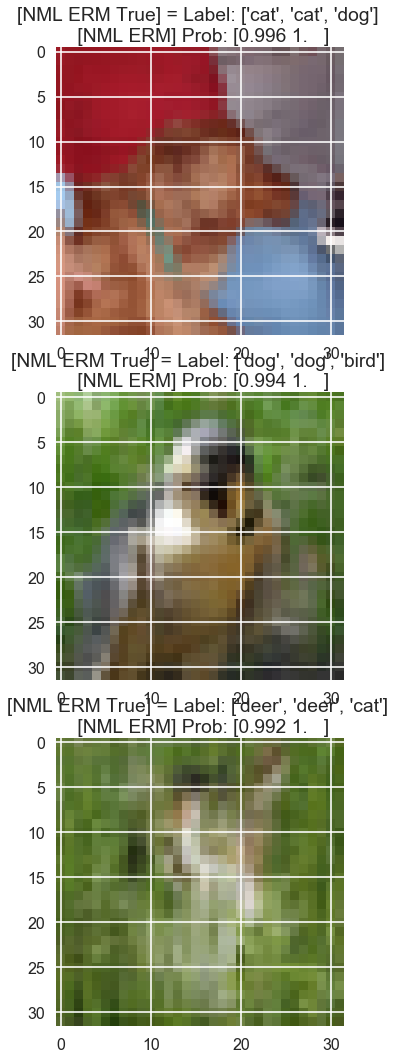

In [27]:
# Given a dict an idx, visualize ERM and NMl with prob of each. along with ground truth

# Inputs
results_dict =  load_dict_from_file_list(files_nml_2_layers)
dict_idxes = [158, 384, 456] #disagree_idxes # [245, 246]


# Initialzie dataset and plots
fig = plt.figure(figsize=(20, 6*len(dict_idxes)))
trainloader, testloader, classes =  create_cifar10_dataloaders('../data', 1, 1)

# Loop on dict  idxes
for iter_idx, dict_idx in enumerate(dict_idxes):
    prob_nml, true_label, predicted_label, prob_erm =  extract_probabilities_list(results_dict[str(dict_idx)])
    prob_nml, normalization_factor= execute_normalize_prob(prob_nml)

    # Extract class names
    class_predict_nml = classes[np.argmax(prob_nml)]
    class_predict_erm = classes[np.argmax(prob_erm)]
    class_predict_gt = classes[true_label]
    # Extract image
    data = testloader.dataset.test_data[dict_idx]

    # Plot the image
    ax = fig.add_subplot(len(dict_idxes),1,iter_idx + 1)
    ax.imshow(data)
    ax.set_title('[NML ERM True] = Label: {} \n [NML ERM] Prob: {}'
                 .format([class_predict_nml, class_predict_erm, class_predict_gt],
                         np.round([prob_nml[np.argmax(prob_nml)], prob_erm[np.argmax(prob_erm)]],3)))

plt.show()